In [4]:
import pandas as pd
import CFS
import numpy as np

import sys
import traceback
import warnings
import os
import copy
import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path

from birch_bellwether_v4 import bellwether
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import SMOTE
from sklearn.calibration import CalibratedClassifierCV

In [5]:
data_source1 = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
if platform.system() == 'Darwin' or platform.system() == 'Linux':
    _dir = data_source1 + '/'
else:
    _dir = data_source1 + '\\'
projects = [f for f in listdir(_dir) if isfile(join(_dir, f))]

In [6]:
def prepare_data(path):
    df = pd.read_csv(path)
    df = df.drop(labels = ['Host','Vcs','Project','File','PL','IssueTracking'],axis=1)
    df = df.dropna()
    df = df[['TLOC', 'TNF', 'TNC', 'TND', 'LOC', 'CL', 'NStmt', 'NFunc',
       'RCC', 'MNL', 'avg_WMC', 'max_WMC', 'total_WMC', 'avg_DIT', 'max_DIT',
       'total_DIT', 'avg_RFC', 'max_RFC', 'total_RFC', 'avg_NOC', 'max_NOC',
       'total_NOC', 'avg_CBO', 'max_CBO', 'total_CBO', 'avg_DIT.1',
       'max_DIT.1', 'total_DIT.1', 'avg_NIV', 'max_NIV', 'total_NIV',
       'avg_NIM', 'max_NIM', 'total_NIM', 'avg_NOM', 'max_NOM', 'total_NOM',
       'avg_NPBM', 'max_NPBM', 'total_NPBM', 'avg_NPM', 'max_NPM', 'total_NPM',
       'avg_NPRM', 'max_NPRM', 'total_NPRM', 'avg_CC', 'max_CC', 'total_CC',
       'avg_FANIN', 'max_FANIN', 'total_FANIN', 'avg_FANOUT', 'max_FANOUT',
       'total_FANOUT', 'NRev', 'NFix', 'avg_AddedLOC', 'max_AddedLOC',
       'total_AddedLOC', 'avg_DeletedLOC', 'max_DeletedLOC',
       'total_DeletedLOC', 'avg_ModifiedLOC', 'max_ModifiedLOC',
       'total_ModifiedLOC','Buggy']]
    return df

def get_features(df):
    fs = feature_selector.featureSelector()
    df,_feature_nums,features = fs.cfs_bfs(df)
    return df,features

def apply_cfs(df):
    _cols = df.columns
    y = df.Buggy.values
    X = df.drop(labels = ['Buggy'],axis = 1)
    X = X.values
    selected_cols = CFS.cfs(X,y)
    fss = []
    cols = df.columns[[selected_cols]].tolist()
    cols.append('Buggy')
    for col in _cols:
        if col in cols:
            fss.append(1)
        else:
            fss.append(0)
    return df[cols],cols,fss
    
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

In [7]:
# count = 0
# project_selection = {}
# for project in projects[0:10]:
#     try:
#         project_attr = []
#         path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project
#         print(project)
#         df = prepare_data(path)
#         if df.shape[0] < 50:
#             continue
#         else:
#             count+=1
#         for repeat in range(10):
#             _df,cols,fss = apply_cfs(df)
#             project_attr.append(fss)
#         project_attr = np.array(list(map(sum,zip(*project_attr))))/len(project_attr)
#         print(project_attr)
#         project_attr = [round(x) for x in project_attr]
#         project_selection[project] = project_attr      
#     except ValueError as e:
#         print(e)
#         continue

In [8]:
all_attrs = []
all_attrs_df = pd.DataFrame()

In [15]:
def run_birch(i):
    i = 0
    all_attrs_df = pd.DataFrame()
    selected_attrs = pd.read_pickle('data/1385/projects/selected_attr.pkl')
    selected_attrs = pd.DataFrame.from_dict(selected_attrs,orient='index')
    path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
    meta_path = 'data/1385/projects/selected_attr.pkl'
    _data_store_path = 'data/1385/new_bellwether_pre_re_pf_v2/2/'
    attr_dict = pd.read_pickle(meta_path)
    attr_df = pd.DataFrame.from_dict(attr_dict,orient='index')
    attr_df_index = list(attr_df.index)
    kf = KFold(n_splits=10,random_state=24)
    data_store_path = _data_store_path
    data_store_path = data_store_path + 'fold_' + str(i) + '/'
    _attr_df_train = pd.read_pickle(data_store_path+'train_data.pkl')
    data_path = Path(data_store_path)
    if not data_path.is_dir():
        os.makedirs(data_path)
    bell = bellwether(path,_attr_df_train)
    cluster,cluster_tree,max_depth = bell.build_BIRCH()
    cluster_ids = []
    for key in cluster_tree:
        if cluster_tree[key].depth == 2:
            #print(cluster_tree[key].parent_id)
            if cluster_tree[key].parent_id not in cluster_ids:
                cluster_ids.append(cluster_tree[key].parent_id)

    df_bells = pd.read_csv(data_store_path + 'bellwether_cdom_1.csv')
    bells = []
    print(cluster_ids)
    for bell_w in df_bells.bellwether.values.tolist():
        for key in cluster_ids:
            if cluster_tree[key].depth == 1:
                #print(cluster_tree[key].parent_id)
                if bell_w in cluster_tree[key].data_points:
                    bells.append(bell_w)
    df_bells.columns = ['cluster_ids','recall',  'precision', 'pf',  'cdom','bellwether']
    df_bells = df_bells[df_bells.bellwether.isin(bells)]
#     print(df_bells)
    sub_selected_attrs = selected_attrs[selected_attrs.index.isin(df_bells.bellwether.values.tolist())]
    all_attrs_df = pd.concat([all_attrs_df,sub_selected_attrs],axis = 0)
    return all_attrs_df,cluster_ids,df_bells

In [38]:
num_cluster = []
_max = {}
for i in range(1):
    fold = str(i)
    #cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/level_2/fold_' + fold
    all_attrs_df,cluster_ids,df_bells = run_birch(i)
    num_cluster.append(df_bells.shape[0])
    all_coefs = check_metrics(all_attrs_df)
    print(all_coefs)
    unq_key = {}
    for key in all_coefs.keys():
        if '_' in key:
            if key.split('_')[1] not in unq_key:
                if key.split('_')[1] not in unq_key.keys():
                    unq_key[key.split('_')[1]] = []
#                 unq_key.append(key.split('_')[1])
                unq_key[key.split('_')[1]].append(key.split('_')[1])
        else:
            if key not in unq_key.keys():
                unq_key[key] = []
            unq_key[key].append(key)
    print(len(unq_key))
    print(unq_key)
    break
        

[cluster_id=0] N_children: 7 N_samples: 627
> [cluster_id=1] N_children: 0 N_samples: 1
> [cluster_id=2] N_children: 0 N_samples: 1
> [cluster_id=3] N_children: 5 N_samples: 55
> > [cluster_id=4] N_children: 0 N_samples: 9
> > [cluster_id=5] N_children: 0 N_samples: 9
> > [cluster_id=6] N_children: 0 N_samples: 7
> > [cluster_id=7] N_children: 0 N_samples: 17
> > [cluster_id=8] N_children: 0 N_samples: 13
> [cluster_id=9] N_children: 10 N_samples: 127
> > [cluster_id=10] N_children: 0 N_samples: 3
> > [cluster_id=11] N_children: 0 N_samples: 9
> > [cluster_id=12] N_children: 0 N_samples: 19
> > [cluster_id=13] N_children: 0 N_samples: 15
> > [cluster_id=14] N_children: 0 N_samples: 4
> > [cluster_id=15] N_children: 0 N_samples: 17
> > [cluster_id=16] N_children: 0 N_samples: 15
> > [cluster_id=17] N_children: 0 N_samples: 19
> > [cluster_id=18] N_children: 0 N_samples: 11
> > [cluster_id=19] N_children: 0 N_samples: 15
> [cluster_id=20] N_children: 16 N_samples: 183
> > [cluster_id=21]

In [28]:
num_cluster

[4, 5, 7, 6, 6, 6, 6, 6, 6, 6, 4, 5, 7, 6, 6, 6, 6, 6, 6, 6]

In [20]:
def get_predicted(cluster_data_loc,metrices_loc,fold,data_location):
    train_data = pd.read_pickle(cluster_data_loc + '/train_data.pkl')
    project = train_data.index.values.tolist()
    _s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + project[0]
    s_df = prepare_data(_s_path)
    s_cols = s_df.columns
    train_data.columns = s_cols
    result = train_data.sum(axis = 0)
    return result.values.tolist(),s_cols


In [28]:
final_list = []
for i in range(1):
    fold = str(i)
    data_location = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
    cluster_data_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/new_bellwether_pre_re_pf_v2/2/fold_' + fold
    metrices_loc = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
    results,s_cols = get_predicted(cluster_data_loc,metrices_loc,fold,data_location)
    final_list.append(results)
final_df = pd.DataFrame(final_list,columns=s_cols)
print(all_attrs_df.NRev)


monetdb.csv      1.0
qse.csv          1.0
codesmith.csv    0.0
ftm.csv          1.0
Name: NRev, dtype: float64


               Buggy  NFix  NRev   CL  RCC  total_DeletedLOC  total_AddedLOC  \
monetdb.csv      1.0   1.0   1.0  0.0  1.0               0.0             0.0   
qse.csv          1.0   1.0   1.0  0.0  0.0               1.0             0.0   
codesmith.csv    1.0   1.0   0.0  1.0  1.0               0.0             0.0   
ftm.csv          1.0   1.0   1.0  1.0  1.0               0.0             0.0   

               max_ModifiedLOC  total_ModifiedLOC  avg_FANIN  ...  total_NIM  \
monetdb.csv                1.0                0.0        0.0  ...        0.0   
qse.csv                    1.0                1.0        0.0  ...        1.0   
codesmith.csv              0.0                0.0        0.0  ...        0.0   
ftm.csv                    0.0                1.0        0.0  ...        0.0   

               avg_NOM  avg_DIT.1  total_DIT.1  max_DIT.1  total_NOC  TLOC  \
monetdb.csv        0.0        0.0          0.0        0.0        0.0   0.0   
qse.csv            0.0        0.0         

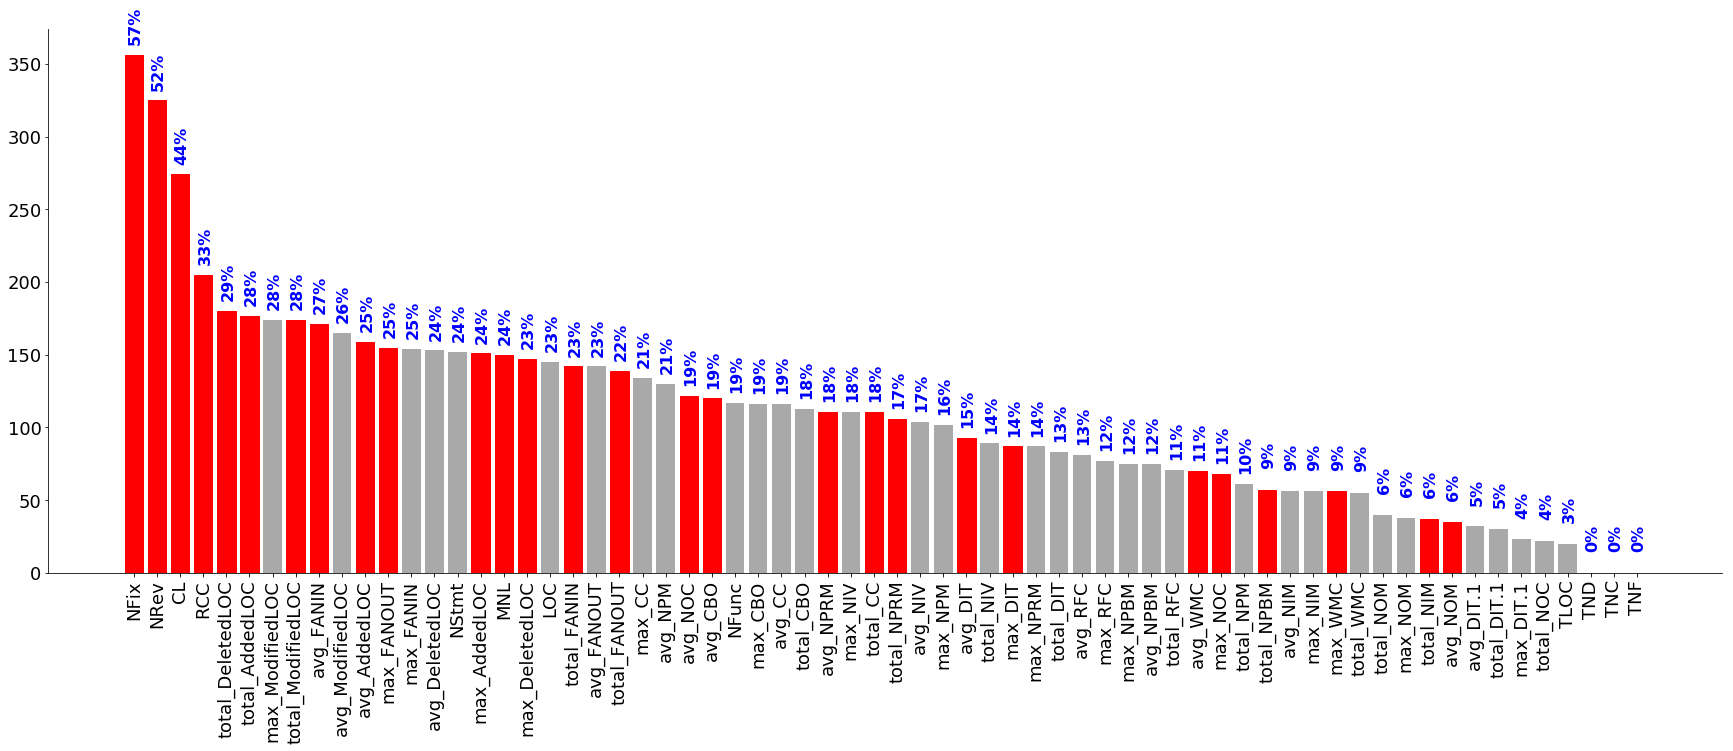

In [64]:
fig, ax = plt.subplots(figsize=(30, 10)) 
x_pos = range(len(final_df.iloc[0].values.tolist())-1)
y = final_df.iloc[0].sort_values(ascending=False)
barlist = plt.bar(y.index.tolist()[1:], y.values.tolist()[1:],color = 'darkgray')
ax.set_xticks(x_pos, y.index.tolist()[1:])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(len(y.values.tolist()[1:])):
    v = y.values.tolist()[1:][i]
    z = y.values.tolist()[1:][i]
    ax.text(i-0.25,v+25 , str(int(round((v/627)*100,0))) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')
    #ax.text(i-0.25,v+25 , str(i) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')
all_attrs_df = all_attrs_df[y.index]
print(all_attrs_df)
for i in range(all_attrs_df.shape[0]):
    proj = all_attrs_df.iloc[i]
    for j in range(proj.shape[0]-1):
        if all_attrs_df.iloc[i,j] == 1:
            
            barlist[j].set_color('red')
# barlist[7].set_color('red')
# barlist[27].set_color('red')
# barlist[30].set_color('red')
# barlist[42].set_color('red')
# barlist[43].set_color('red')
# barlist[44].set_color('red')
# barlist[46].set_color('red')
# barlist[49].set_color('red')
plt.xticks(fontsize=18,rotation='vertical')
plt.yticks(fontsize=18)
#plt.show()
plt.savefig('fss.pdf',dpi=600)

In [23]:
bell_clusters = {}
for i in range(df_bells.shape[0]):
    bell_clusters[df_bells.loc[i,'bellwether']] = df_bells.loc[i,'cluster_ids']

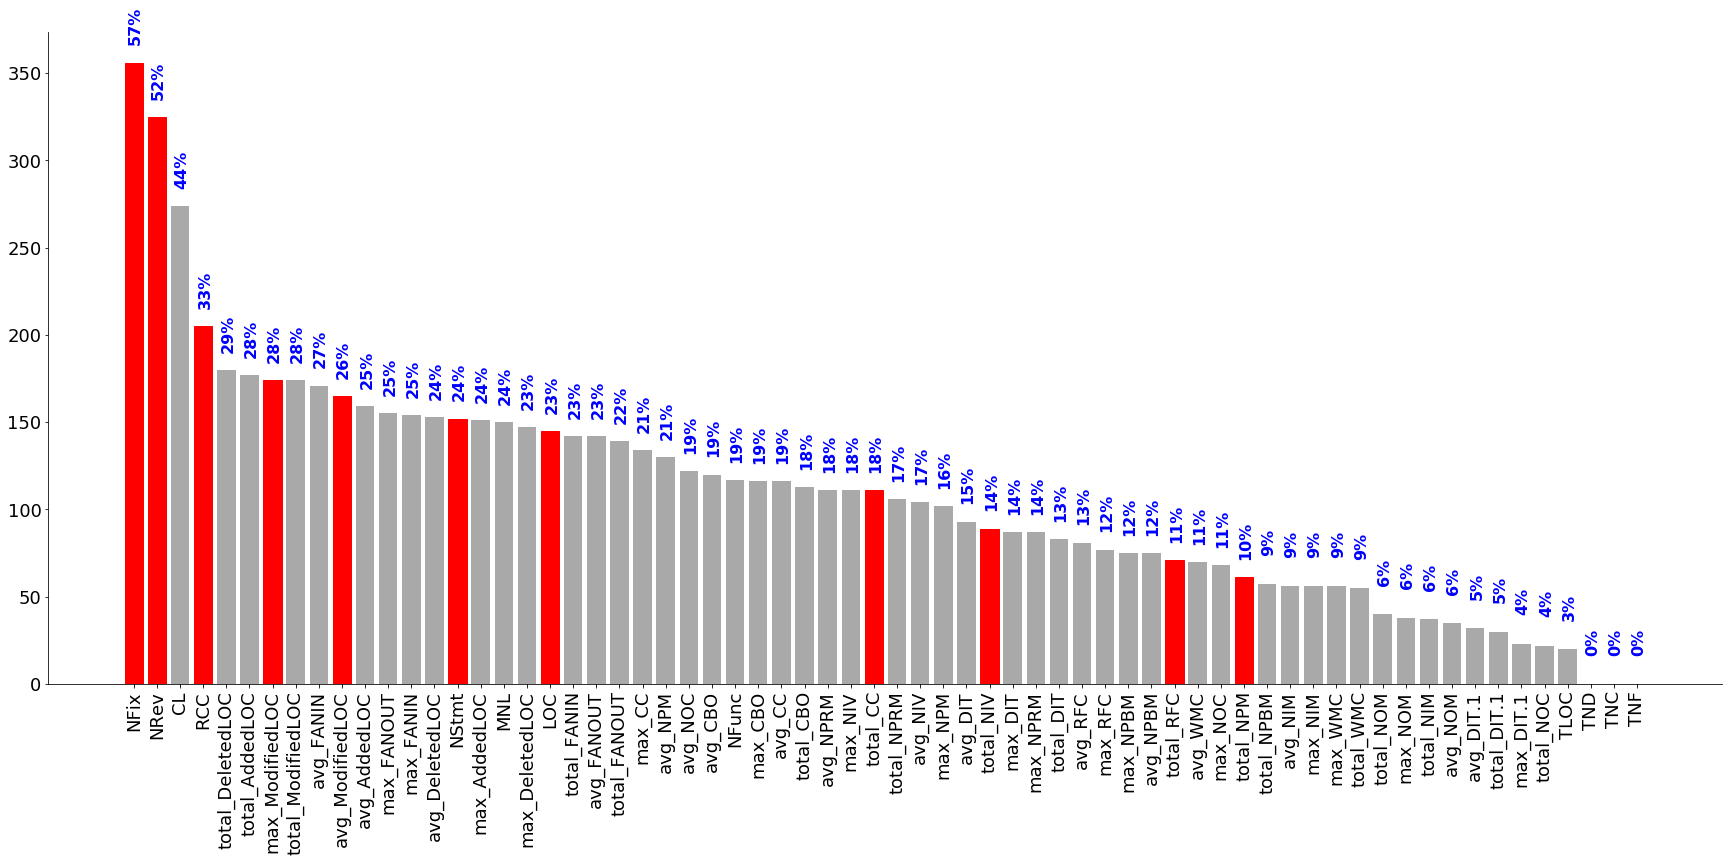

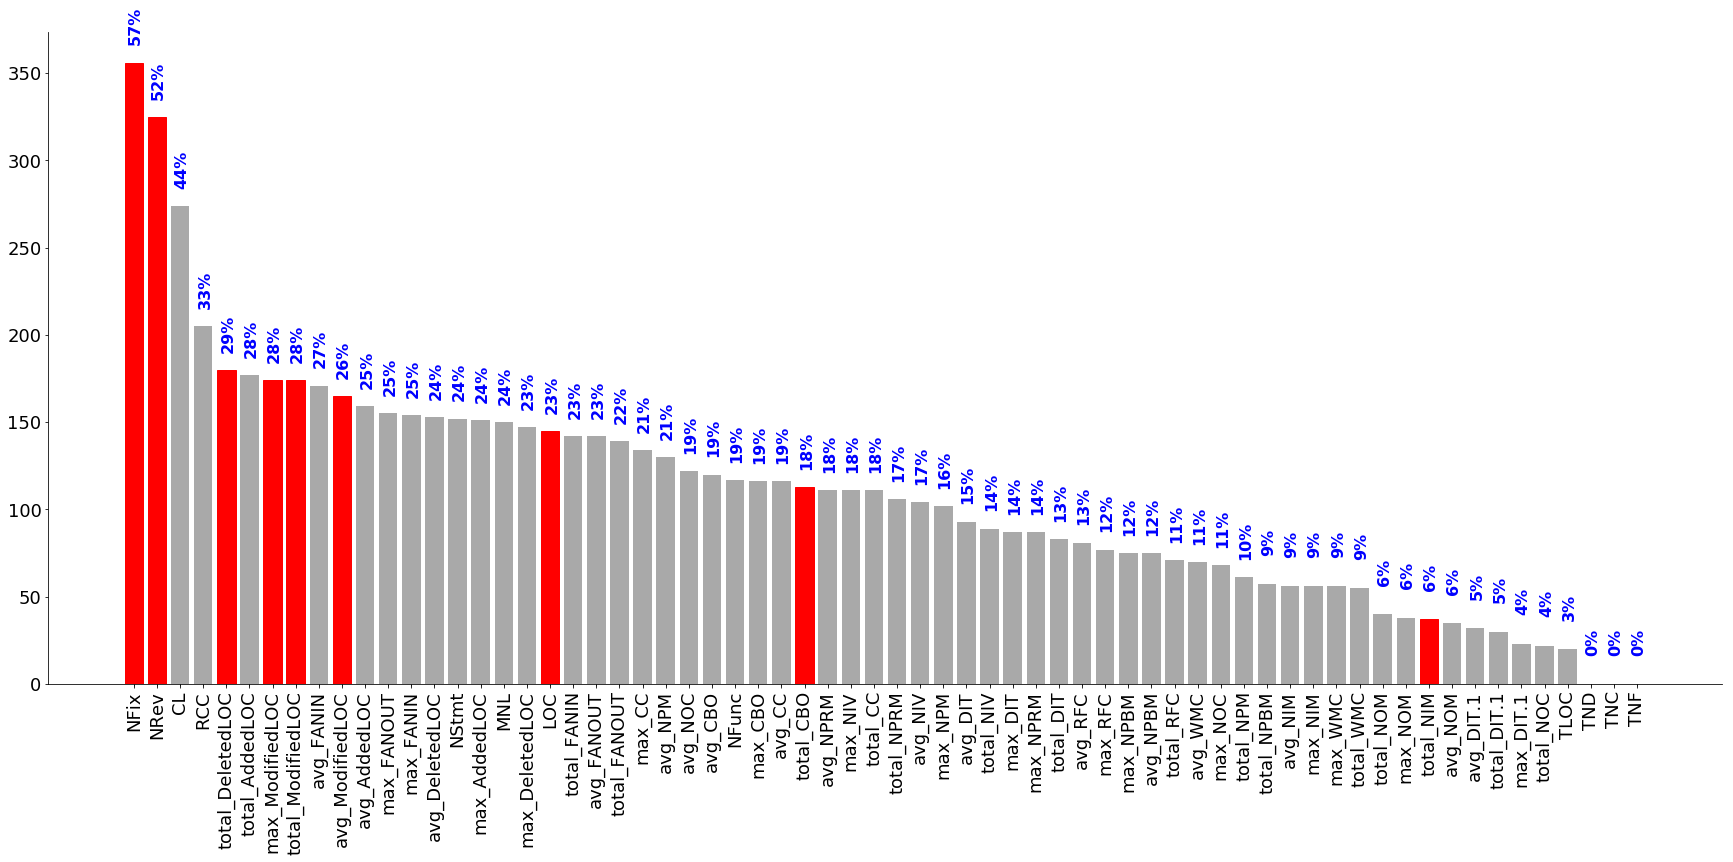

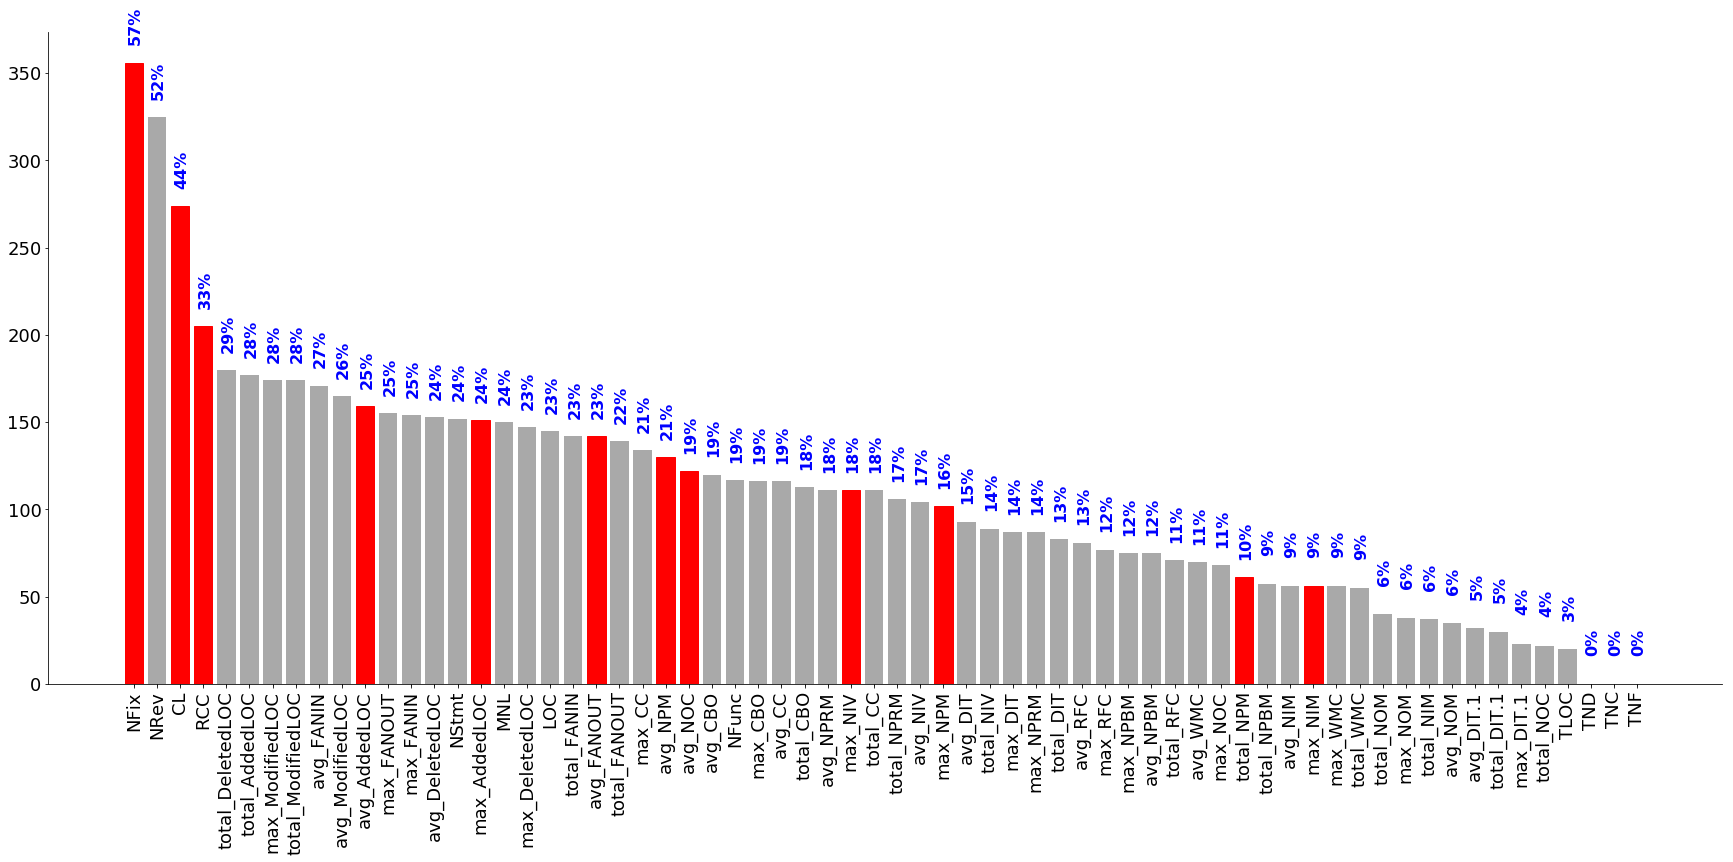

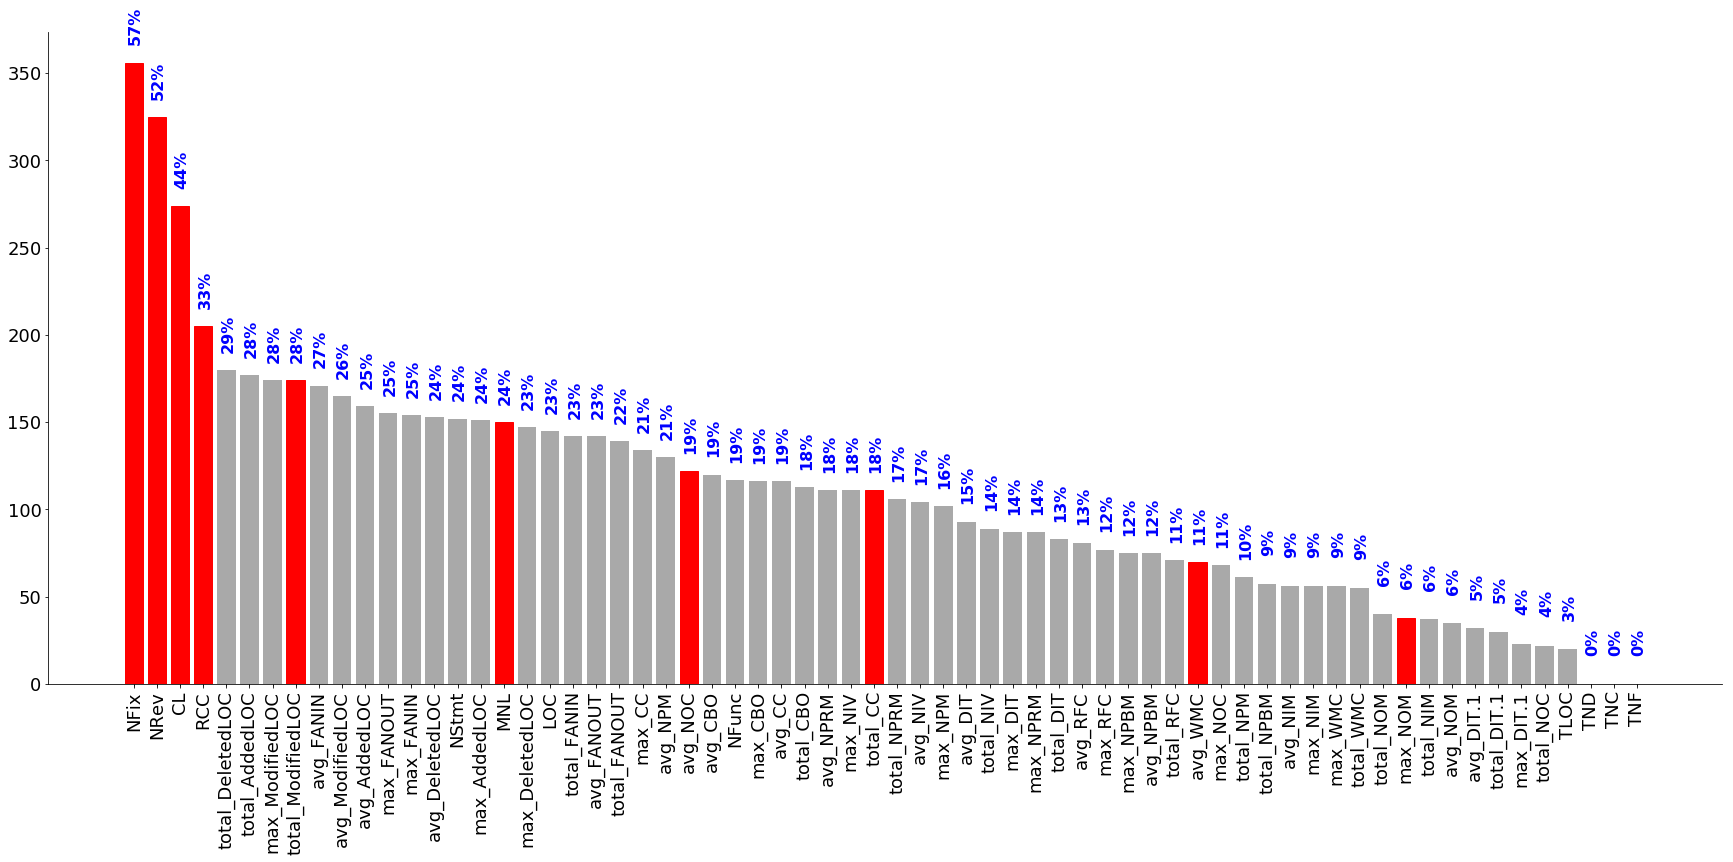

In [87]:
# fig = plt.figure(figsize=(60, 40))
# subs = [421,422,423,424]
clu = 1
for x in range(all_attrs_df.shape[0]):
#     fig = plt.figure(figsize=(60, 40))
    proj = all_attrs_df.iloc[x]
    proj = proj[1:]
    fig, ax = plt.subplots(figsize=(30, 12)) 
#     ax = fig.add_subplot()
    x_pos = range(len(final_df.iloc[0].values.tolist())-1)
    y = final_df.iloc[0].sort_values(ascending=False)
    barlist = plt.bar(y.index.tolist()[1:], y.values.tolist()[1:],color = 'darkgray')
    ax.set_xticks(x_pos, y.index.tolist()[1:])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_title("Cluster: " + str(bell_clusters[all_attrs_df.index[x]]) + all_attrs_df.index[x],size = 25)
#     ax.set_title("Cluster: " + str(clu),size = 25)
    clu += 1
    for i in range(len(y.values.tolist()[1:])):
        v = y.values.tolist()[1:][i]
        z = y.values.tolist()[1:][i]
        ax.text(i-0.25,v+25 , str(int(round((v/627)*100,0))) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')
        #ax.text(i-0.25,v+25 , str(i) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')

#     for j in range(proj.shape[0]-1):
# #         print(all_attrs_df.iloc[x])
#         if all_attrs_df.iloc[x,j] == 1:
#             barlist[j].set_color('red')
    
    for j in range(proj.shape[0]):
        if proj.iloc[j] == 1:
            barlist[j].set_color('red')

    plt.xticks(fontsize=18,rotation=90)
    plt.yticks(fontsize=18)
    plt.show()
    fig.savefig('fss_all' + str(x) + '.pdf')


In [1]:
path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/'
for x in range(all_attrs_df.shape[0]):
    proj = all_attrs_df.index[x]
    print(proj)
    data_path = path + proj
    df = prepare_data(data_path)
    df.reset_index(drop=True,inplace=True)
    d = {'buggy': True, 'clean': False}
    df['Buggy'] = df['Buggy'].map(d)
    df, s_cols,fss = apply_cfs(df)
    print(s_cols)
    #s_cols = df.columns.tolist()
    df = apply_smote(df)
    df.to_csv('coefs/data/' + proj,index = False)
    y = df.Buggy
    X = df.drop(labels = ['Buggy'],axis = 1)
    print(X.shape)

NameError: name 'all_attrs_df' is not defined

In [ ]:
path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/'
fig = plt.figure(figsize=(30, 40))
subs = [411,412,413,414]
fig_list = {}
coefs = {}
for x in range(all_attrs_df.shape[0]):
    proj = all_attrs_df.iloc[x]
#     fig, ax = plt.subplots(figsize=(30, 10)) 

    data_path = path + all_attrs_df.index[x]
    df = prepare_data(data_path)
    df.reset_index(drop=True,inplace=True)
    d = {'buggy': True, 'clean': False}
    df['Buggy'] = df['Buggy'].map(d)
    df, s_cols,fss = apply_cfs(df)
    df = apply_smote(df)
    train_y = df.Buggy
    train_X = df.drop(labels = ['Buggy'],axis = 1)
    
    clf = LogisticRegression(random_state=42)
    clf.fit(train_X,train_y)
    
    ax = fig.add_subplot(subs[x])
    x_pos = range(len(final_df.iloc[0].values.tolist())-1)
    y = final_df.iloc[0].sort_values(ascending=False)
    
    count = 0
    for i in y.index:
        if i == 'Buggy':
            continue
        fig_list[i] = count
        count += 1
    
    
    barlist = plt.bar(y.index.tolist()[1:], y.values.tolist()[1:],color = 'darkgray')
    ax.set_xticks(x_pos, y.index.tolist()[1:])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Cluster: " + str(bell_clusters[all_attrs_df.index[x]]) + all_attrs_df.index[x],size = 25)
    for i in range(len(y.values.tolist()[1:])):
        v = y.values.tolist()[1:][i]
        z = y.values.tolist()[1:][i]
        ax.text(i-0.25,v+25 , str(int(round((v/627)*100,0))) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')
        #ax.text(i-0.25,v+25 , str(i) + '%', color='blue', fontweight='bold',fontsize=16,rotation='vertical')

    for _col in s_cols:
        if _col == 'Buggy':
            continue
        barlist[fig_list[_col]].set_color('red')

    plt.xticks(fontsize=18,rotation='vertical')
    plt.yticks(fontsize=18)
    plt.subplots_adjust(hspace=0.5)
    
    
    
plt.show()
fig.savefig('fss.pdf',dpi=600)

In [148]:
path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/'
fig_list = {}
coefs = {}
for x in range(all_attrs_df.shape[0]):
    proj = all_attrs_df.iloc[x]
#     fig, ax = plt.subplots(figsize=(30, 10)) 

    data_path = path + all_attrs_df.index[x]
    df = prepare_data(data_path)
    df.reset_index(drop=True,inplace=True)
    d = {'buggy': True, 'clean': False}
    df['Buggy'] = df['Buggy'].map(d)
    df, s_cols,fss = apply_cfs(df)
    df = apply_smote(df)
    train_y = df.Buggy
    train_X = df.drop(labels = ['Buggy'],axis = 1)
    
    clf = LogisticRegression(random_state=42)
    clf.fit(train_X,train_y)
    columns = train_X.columns.values
    coef = clf.coef_[0]
    if all_attrs_df.index[x] not in coefs.keys():
        coefs[all_attrs_df.index[x]] = {}
    for i in range(len(columns)):
        coefs[all_attrs_df.index[x]][columns[i]] = coef[i]
for key in coefs:
    coefs_df = pd.DataFrame.from_dict(coefs[key], orient = 'index')
    coefs_df.to_csv('coefs/' + key)

In [17]:
def check_metrics(all_attrs_df):
#     attr_df = pd.read_pickle('/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/src/data/1385/projects/selected_attr.pkl')
    path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/'
#     attr_df = pd.DataFrame.from_dict(attr_df,orient='index')
    all_attrs_df.columns = ['TLOC', 'TNF', 'TNC', 'TND', 'LOC', 'CL', 'NStmt', 'NFunc',
        'RCC', 'MNL', 'avg_WMC', 'max_WMC', 'total_WMC', 'avg_DIT', 'max_DIT',
        'total_DIT', 'avg_RFC', 'max_RFC', 'total_RFC', 'avg_NOC', 'max_NOC',
        'total_NOC', 'avg_CBO', 'max_CBO', 'total_CBO', 'avg_DIT.1',
        'max_DIT.1', 'total_DIT.1', 'avg_NIV', 'max_NIV', 'total_NIV',
        'avg_NIM', 'max_NIM', 'total_NIM', 'avg_NOM', 'max_NOM', 'total_NOM',
        'avg_NPBM', 'max_NPBM', 'total_NPBM', 'avg_NPM', 'max_NPM', 'total_NPM',
        'avg_NPRM', 'max_NPRM', 'total_NPRM', 'avg_CC', 'max_CC', 'total_CC',
        'avg_FANIN', 'max_FANIN', 'total_FANIN', 'avg_FANOUT', 'max_FANOUT',
        'total_FANOUT', 'NRev', 'NFix', 'avg_AddedLOC', 'max_AddedLOC',
        'total_AddedLOC', 'avg_DeletedLOC', 'max_DeletedLOC',
        'total_DeletedLOC', 'avg_ModifiedLOC', 'max_ModifiedLOC',
        'total_ModifiedLOC','Buggy']
    coefs = {}
    all_coefs = {}
    for x in range(all_attrs_df.shape[0]):
        proj = all_attrs_df.iloc[x]
#         print(all_attrs_df.index[x])
#         print(proj.where(proj == 1).dropna().index.values.tolist())
        s_cols = proj.where(proj == 1).dropna().index.values.tolist()
#         print(all_attrs_df.index[x],all_attrs_df.iloc[x].where(all_attrs_df.iloc[x] = 1))
        data_path = path + all_attrs_df.index[x]
        df = prepare_data(data_path)
        df.reset_index(drop=True,inplace=True)
        d = {'buggy': True, 'clean': False}
        df['Buggy'] = df['Buggy'].map(d)
#         df, s_cols,fss = apply_cfs(df)
#         print(s_cols)
#         df = apply_smote(df)
        df = df[s_cols]
        train_y = df.Buggy
        train_X = df.drop(labels = ['Buggy'],axis = 1)

        clf = LogisticRegression(random_state=42)
        clf.fit(train_X,train_y)
        columns = train_X.columns.values
        coef = clf.coef_[0]
        if all_attrs_df.index[x] not in coefs.keys():
            coefs[all_attrs_df.index[x]] = {}
        for i in range(len(columns)):
            coefs[all_attrs_df.index[x]][columns[i]] = round(coef[i],2)
        for i in range(len(columns)):
            if columns[i] not in all_coefs.keys():
                all_coefs[columns[i]] = []
            all_coefs[columns[i]].append(round(coef[i],2))
#         print(coefs[all_attrs_df.index[x]])
    return all_coefs


In [131]:
check_metrics(all_attrs_df)

gpsmid.csv
['NStmt', 'NFunc', 'avg_WMC', 'total_WMC', 'total_CBO', 'total_NPBM', 'avg_NPRM', 'max_NPRM', 'total_NPRM', 'avg_CC', 'max_CC', 'total_FANIN', 'NRev', 'max_AddedLOC', 'total_AddedLOC', 'Buggy']
{'NStmt': -0.49, 'NFunc': -0.75, 'avg_WMC': 0.39, 'total_WMC': 0.86, 'total_CBO': 0.11, 'total_NPBM': 0.57, 'avg_NPRM': 0.57, 'max_NPRM': 0.71, 'total_NPRM': 0.13, 'avg_CC': -0.24, 'max_CC': -0.26, 'total_FANIN': -0.07, 'NRev': 0.66, 'max_AddedLOC': 0.03, 'total_AddedLOC': -0.26}
sblim.csv
['MNL', 'total_WMC', 'max_DIT', 'total_DIT', 'avg_RFC', 'total_RFC', 'avg_NOC', 'max_NOC', 'max_DIT.1', 'total_DIT.1', 'total_NIV', 'avg_NIM', 'avg_NOM', 'avg_CC', 'max_CC', 'max_FANOUT', 'total_FANOUT', 'NFix', 'Buggy']
{'MNL': 0.36, 'total_WMC': 0.47, 'max_DIT': 0.28, 'total_DIT': -0.51, 'avg_RFC': -0.17, 'total_RFC': 0.42, 'avg_NOC': -0.2, 'max_NOC': -0.2, 'max_DIT.1': 0.28, 'total_DIT.1': -0.51, 'total_NIV': 0.18, 'avg_NIM': -0.33, 'avg_NOM': 0.17, 'avg_CC': -0.69, 'max_CC': 0.17, 'max_FANOUT': 